# Analyze A/B Test Results 

 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.


<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzesas we set up
random.seed(42)


Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>



**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [3]:
# reading the data
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [4]:
df.shape

(294478, 5)

**c.** The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [6]:
(df.converted == 1).mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [7]:
(df[(df['group'] == 'treatment') == (df['landing_page'] != 'new_page')]).shape[0]

3893

In [8]:
(df[(df['group'] == 'control') == (df['landing_page'] != 'old_page')]).shape[0]

3893

**f.** Do any of the rows have missing values?

In [9]:
(df[df.isnull().any(axis=1)]).shape[0]

0

 
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  



**a.** Now create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df.drop((df[(df['group'] == 'treatment') == (df['landing_page'] != 'new_page')]).index, axis =0)

In [11]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

 
Use **df2** and the cells below 

**a.** How many unique **user_id**s are in **df2**?

In [12]:
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [13]:
sum(df2.user_id.duplicated())

1

**c.** Display the rows for the duplicate **user_id**? 

In [14]:
#show both rows and delete one of them
user = df2[df2.duplicated(['user_id'], keep = 'first')]
user2 = df2[df2.duplicated(['user_id'], keep = 'last')]
print(user)
print(user2)

      user_id                   timestamp      group landing_page  converted
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0
      user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [15]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2.drop((user).index,inplace = True, axis=0)
# Check again if the row with a duplicate user_id is deleted or not


In [16]:
df2.count()[0]

290584

 

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>



In [17]:
Ppopulation = len(df2.query(' converted == 1'))/ len(df2['converted'])
print(Ppopulation )

0.11959708724499628


**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
#probability of control
poc = (df2.query(' group == "control" ')['converted']==1).mean()
print(poc)

0.1203863045


**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
# probability of treatment
pot = (df2.query(' group == "treatment"')['converted']==1).mean()
print(pot)

0.118808065515


In [20]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = pot - poc 
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [21]:
#probability of new page
ponp = len(df2.query('landing_page == "new_page"')['user_id'])/len(df2.user_id)
print(ponp)

0.5000619442226688


**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

**My answer .**
 We  have 12% who purchased from control group (or old page), and it's approximately the same proportion for treatment group (or new page): 11.88%    and for general conversions : 11.96% ....so through this analysis I don't think we have enough evidence to say that the new treatment page leads to more conversions.... alors, let's go to the next step...

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  



For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page . 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

>**My answer .**
> **$H_0$**: **$p_{new}$** ≤ **$p_{old}$**

>**$H_1$**: **$p_{new}$** > **$p_{old}$**

### - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation. 

In [22]:
pnf = 0.05 / df.shape[0]
pnf

1.6979197087728117e-07

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [23]:
pnew = df2['converted'].mean()
pnew

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [24]:
pold = df2['converted'].mean()
pold

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>


In [25]:
n_new = df2.query(" group == 'treatment'").user_id.count()
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [26]:
n_old = df2.query(" group == 'control'").user_id.count()
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>


In [27]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([1, 0], size=n_new, replace = True, p=(pnew, 1-pnew))
N = new_page_converted.mean()
N

0.12061110728786732

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [28]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([1, 0], size= n_old, replace = True, p=(pold, 1-pold))
O = old_page_converted.mean()
O

0.11963599818274433

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [29]:
# O : old_page_converted_mean and N : new_page_converted_mean
N - O

0.00097510910512299542


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [30]:
# Sampling distribution 
#p_diffs = []
#for _ in range (10000): 
#    new_sample = np.random.choice([1, 0], n_new, replace = True, p=(pnew, 1-pnew))
#    old_sample = np.random.choice([1, 0], n_old, replace = True, p=(pold, 1-pold))
#    new_sample_mean = new_sample.mean()
#    old_sample_mean = old_sample.mean()
#    p_diffs.append(new_sample_mean - old_sample_mean)

In [32]:

p_diffs = []
new_converted_simulation = np.random.binomial(n_new, pnew, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, pold, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

In [33]:
p_diffs = np.array(p_diffs)

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  



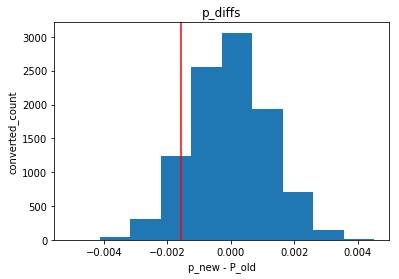

In [34]:
plt.hist(p_diffs)
plt.axvline(x = obs_diff, c = 'r')
plt.title('p_diffs')
plt.xlabel('p_new - P_old')
plt.ylabel('converted_count');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [35]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = pot - poc
obs_diff

-0.0015782389853555567

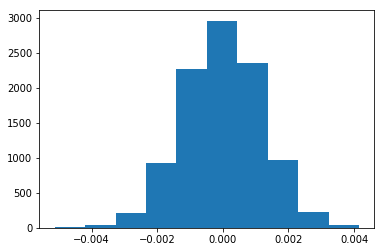

In [36]:
# calculate the null_values and plot it
p_diffs_std = p_diffs.std()
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
plt.hist(null_vals);

In [37]:
# compute p value
pval = (null_vals > obs_diff).mean()
pval

0.90490000000000004

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

>**my answer .**
>In part j. ,i calculated the p value = 0.906, if this value is >=  0.05 then there is no difference between the new and old page, or even more the old page is better than the new one, hence we fail to reject the null hypotheses.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [40]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query(" landing_page == 'old_page' & converted == 1").shape[0]

# number of conversions with the new_page
convert_new = df2.query("landing_page == 'new_page' & converted == 1").shape[0]

# number of individuals who were shown the old_page
n_old = df2[df2['group'] == 'control'].shape[0]

# number of individuals who received new_page
n_new = df2[df2['group'] == 'treatment'].shape[0]



m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  

In [41]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old],[n_new, n_old],alternative='larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>



>**My answer.**
> i'm not sure about the z_score, but i'm pretty sure about the p_value [0.90, (90%)],
well, it's approxmetly tha same porpotion from part j.....  both values are greater than type1 error rate [0.05, (5%)], This means that our null hypothesis is the right decision, because it means that the old page is equal to or even more better than the new page , hence we fail to reject the null hypotheses....voila, let's go to the last part...

<a id='regression'></a>
### Part III - A regression approach


In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**MY answer .** 
> this means we're going to predict catigorical variables, then i'll perform the logistic regression

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [42]:
# intercept and dummies
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

In [43]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [44]:
# i'll use the logistic regression model
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])

results = logit_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [45]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-07-25 20:36 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [46]:
#exponentiate the coefficients for ab_page
1/ np.exp( -0.0150)

1.0151130646157189

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  



>**My answer .** 
> here we computedt the p_value [0.189, (18.9%)] depending on two sided test, and it turns out that it's not statistical significant becuase there is no relationship between the conversion rate and ab_page........Otherwise, part 2, it's a one-sided test, we've been trying to prove statistically whether the old_page is better or not

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**My answer .**
> it is a good idea to consider other factors to add to the model, it'll provide us more accurate, clear and informative data,  On the other hand, adding more terms may cause misleading data(eg: VIF) or an unhelpful model

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 



In [47]:
# Read the countries.csv
df_mer = pd.read_csv('countries.csv')
df_mer.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [48]:
# Join with the df2 dataframe
df_merged = df2.set_index('user_id').join(df_mer.set_index('user_id'), how = 'inner')
df_merged.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country
user_id,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [49]:
#counting country values
df_merged['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [50]:
# Create the necessary dummy variables
df_merged[['UK', 'US', 'CA',]] = pd.get_dummies(df_merged['country'])
df_merged.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US,CA
user_id,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [51]:
# Fit your model, and summarize the results
logit_mod = sm.Logit(df_merged['converted'], df_merged[['intercept','ab_page','UK', 'CA']])

results = logit_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [52]:
#the results
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-07-25 20:36 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9794    0.0127  -155.4145  0.0000  -2.0044  -1.9544
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
UK           -0.0506    0.0284    -1.7835  0.0745  -0.1063   0.0050
CA           -0.0099    0.0133    -0.7433  0.4573  -0.0359   0.0162
==================================================================

"""

In [53]:
1/ np.exp(-0.0149), 1/ np.exp(-0.0506), 1/ np.exp(-0.0099) 

(1.0150115583846535, 1.0519020483004984, 1.009949167117542)

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 



In [54]:
df_merged['CA_page']= df_merged['CA']* df_merged['ab_page']
df_merged['UK_page']= df_merged['UK']* df_merged['ab_page']
df_merged.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US,CA,CA_page,UK_page
user_id,,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,1,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,1,0
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0


In [55]:
# Fit the model, summarize the results
logit_mod = sm.Logit(df_merged['converted'], df_merged[['intercept','ab_page','UK', 'CA', 'CA_page', 'UK_page']])
results2 = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [56]:
#the results
results2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-07-25 20:37 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9922    0.0161  -123.4571  0.0000  -2.0238  -1.9606
ab_page       0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
UK           -0.0118    0.0398    -0.2957  0.7674  -0.0899   0.0663
CA            0.0057    0.0188     0.3057  0.7598  -0.0311   0.0426
CA_page      -0.0314    0.0266    -1.1807  0.2377  -0.0835   0.0207
UK_page      -0.0783    0.0568    -1.3783  0.1681  -0.1896   0.0330
==================================================================

"""

> **My answer** : based on the results and p_values, these terms are not significant and even decrease the significance of the  (UK) columns. hence we should discard

>**My conclusion .**
> alors, In this A/B test, we need to know which page has the highest conversion rate:
> **for the I part** 
- we clean and exploratory the data 
- the proportion of conversion in old page : (12%)
- the proportion of conversion in new page : (11.8%)
- the proportion of conversion regardless the page : (11.9%); he proportion of conversion generally and in
    both pages are approximately the same, we can find the old page is slightly better
- the proportion of receiving the new page : (50%); which means that  individuels receiving both pages equelly 
   
   >**for the II part .**
 It's one-sided test, if we're going to find different results by using bootstrap method
-so first we state the null hypotheses :       Pnew <= Pold
-  bootstraping sample data set for both groups; having  computed the differece in the converted probability for both
samples, perform the sampling distribution, and computed the p_value z_score
- the result is :  p_value = (90%)
-  comparing it with the "Type I error rate (0.05)" : (90%) > 5%,
hence we fail to reject the null hypotheses,
hence the old page is equal or better than the new one.

 >**for the III part .**
 we perform the logistic regression, it's two sided test, to see if there is a significant difference in 
conversion based on the page-type (treatment - control)a customer receives;
- the result: the p_value and coefficient not statistical significant becuase there is no relationship between the conversion rate and ab_page
- For every 1 unit decrease in ab_page, conversion is 1.015 times as likely, holding all other variables constant.
>**for the second part .** we add country to see if it had an impact on conversion:
- the result: the p_value and coefficient not statistical significant becuase there is no relationship between the conversion rate and ab_page, UK and CA
- Coef. for ab_page (-0.0149), exp(1.015) :For every 1 unit decrease in ab_page, conversion is 1.015 times less likely, if a user receives the treatment page, holding all other variables constant.
- Coef. for UK (-0.0506), exp(1.0519) : For every 1 unit decrease in UK , conversion is 1.052 times less likely, if the user lives in UK and not thr US.
- Coef. for CA (-0.0099), exp(1.009) :For every 1 unit decrease in CA , conversion is 1.009 times less likely, if the user lives in CA and not thr US.
we should discard this model

> ** Here we end, after this long jounry, it turns out in all cases that the old page has a higher conversion rate than the new page, even though it's just slightly different, i recommed Keep the old webpage and discard the new one.



In [57]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0